# Book Recommendation Using Collaborative Filtering

# Import Library

In [1]:
from google.colab import files
import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


# Data Understanding

Dataset yang digunakan dalam proyek ini berasal dari Kaggle dengan judul [Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data).

Berdasarkan informasi dari Kaggle, dataset ini terdiri dari tiga file utama yang saling terkait, yaitu:

1. Users (BX-Users.csv)

  Berisi informasi tentang pengguna.
  - Kolom User-ID adalah ID unik pengguna yang telah dianonimkan (dalam bentuk angka).
  - Kolom Location dan Age menyediakan data demografis jika tersedia. Jika tidak tersedia, nilainya berupa NULL.

2. Books (BX-Books.csv)
  
  Menyimpan informasi detail tentang buku yang tersedia.
  - Buku diidentifikasi berdasarkan ISBN yang valid.
  - Informasi tambahan mencakup: Book-Title, Book-Author, Year-Of-Publication, dan Publisher.
  - Dataset ini juga menyediakan URL gambar sampul buku dalam tiga ukuran: kecil (Image-URL-S), sedang (Image-URL-M), dan besar (Image-URL-L). URL ini mengarah ke situs Amazon.
  - Jika sebuah buku memiliki lebih dari satu penulis, hanya penulis pertama yang dicantumkan.

3. Ratings (BX-Book-Ratings.csv)

  Berisi data rating buku oleh pengguna.
  - Rating berupa angka pada skala 1–10 yang menunjukkan tingkat apresiasi (semakin tinggi semakin disukai).
  - Rating 0 dianggap sebagai interaksi implisit (misalnya user melihat atau memiliki buku, tetapi tidak memberikan penilaian eksplisit).

## Data Loading

In [2]:
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Unduh dataset dari Kaggle
!kaggle datasets download -d arashnic/book-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
  0% 0.00/24.3M [00:00<?, ?B/s]
100% 24.3M/24.3M [00:00<00:00, 1.03GB/s]


In [4]:
!unzip book-recommendation-dataset.zip

Archive:  book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


In [5]:
books = pd.read_csv('Books.csv')
ratings = pd.read_csv('Ratings.csv')
users = pd.read_csv('Users.csv')

<ipython-input-5-378180666>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


In [6]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


- books memiliki 271.360 baris dan 8 kolom.
- Terdapat informasi terkait ISBN, judul buku, penulis, tahun terbit, penerbit, serta link gambar buku.
- Namun, terdapat sedikit missing values di kolom Book-Author, Publisher, dan Image-URL-L.



In [8]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


ratings memiliki 1.149.780 entri rating dari pengguna terhadap buku, yang merupakan data utama untuk membangun sistem rekomendasi.


In [10]:
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


- users memiliki 278.858 pengguna.
- Data mencakup User-ID, Location, dan Age, namun kolom Age memiliki banyak missing values

In [12]:
print('Jumlah pengguna unik: ', len(users['User-ID'].unique()))
print('Jumlah buku unik: ', len(books['ISBN'].unique()))
print('Jumlah rating (interaksi) yang diberikan pengguna: ', len(ratings))
print('Jumlah pengguna yang memberikan rating: ', len(ratings['User-ID'].unique()))
print('Jumlah buku yang menerima rating: ', len(ratings['ISBN'].unique()))

Jumlah pengguna unik:  278858
Jumlah buku unik:  271360
Jumlah rating (interaksi) yang diberikan pengguna:  1149780
Jumlah pengguna yang memberikan rating:  105283
Jumlah buku yang menerima rating:  340556


#  Exploratory Data Analysis

## Distribusi Ratings

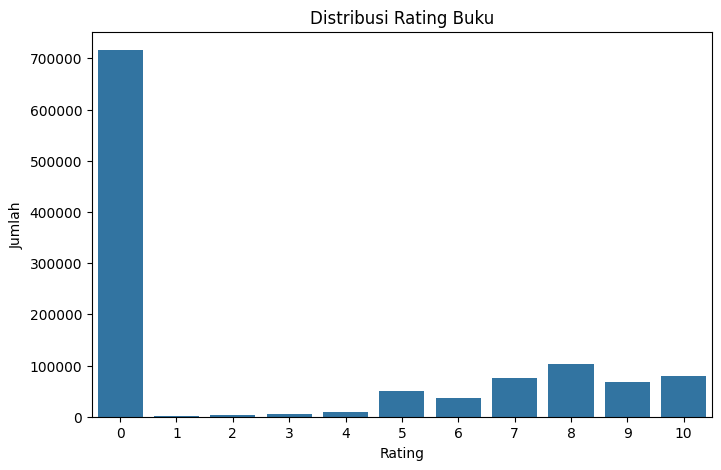

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(data=ratings, x='Book-Rating')
plt.title('Distribusi Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Data rating = 0 perlu ditangani karena merupakan sinyal perilaku pengguna (interaksi implisit), tetapi bukan rating yang menunjukkan tingkat apresiasi.

## Top 10 Buku paling banyak dirating

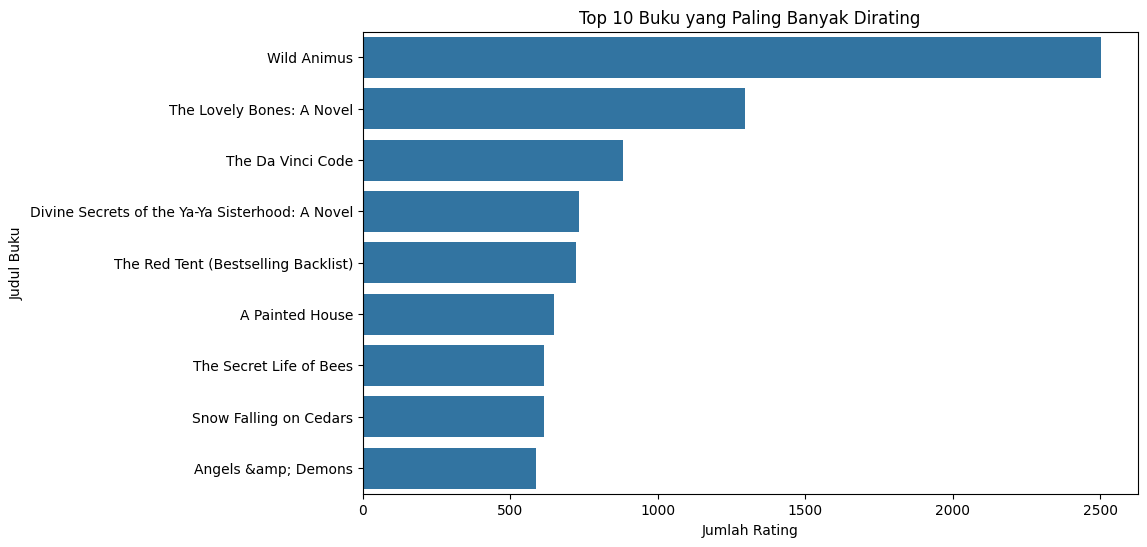

In [14]:
most_rated_books = ratings['ISBN'].value_counts().head(10).reset_index()
most_rated_books.columns = ['ISBN', 'rating_count']
most_rated_books = most_rated_books.merge(books[['ISBN', 'Book-Title']], on='ISBN')

plt.figure(figsize=(10,6))
sns.barplot(data=most_rated_books, y='Book-Title', x='rating_count')
plt.title('Top 10 Buku yang Paling Banyak Dirating')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Buku')
plt.show()

## Distribusi Umur Pengguna

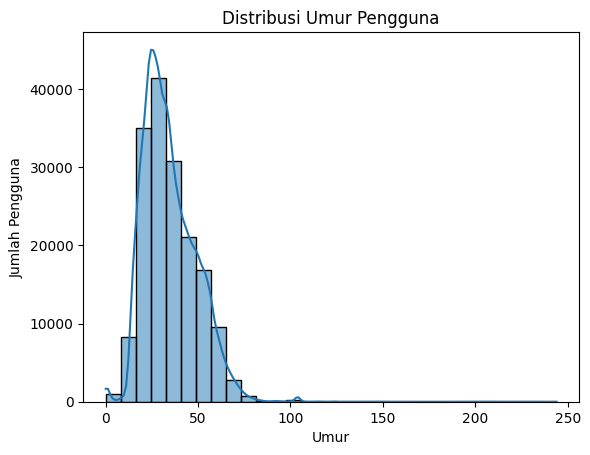

In [15]:
sns.histplot(users['Age'].dropna(), bins=30, kde=True)
plt.title('Distribusi Umur Pengguna')
plt.xlabel('Umur')
plt.ylabel('Jumlah Pengguna')
plt.show()

## 10 User Teraktif

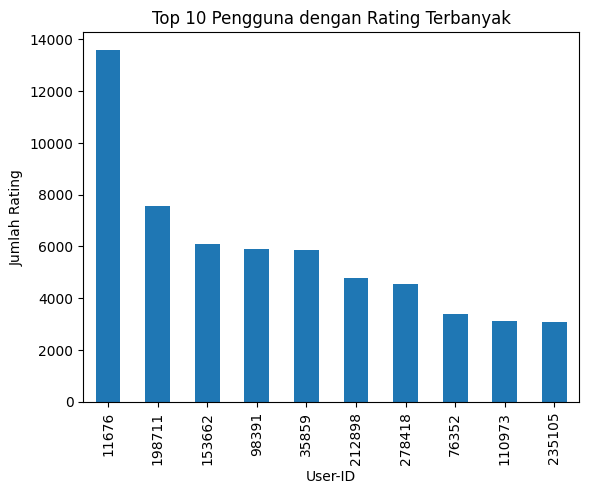

In [16]:
top_users = ratings['User-ID'].value_counts().head(10)
top_users.plot(kind='bar')
plt.title('Top 10 Pengguna dengan Rating Terbanyak')
plt.xlabel('User-ID')
plt.ylabel('Jumlah Rating')
plt.show()


# Data Preprocessing

## Missing value

In [17]:
# Cek missing value
print(books.isnull().sum())
print(users.isnull().sum())

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
User-ID          0
Location         0
Age         110762
dtype: int64


1. Kolom `Book-Author`, `Publisher`, dan `Image-URL-L` memiliki jumlah nilai kosong yang sangat kecil (kurang dari 5 nilai dari total lebih dari 270.000 baris). Oleh karena itu, nilai kosong ini dapat:
  - Diisi dengan teks placeholder seperti `"Unknown"` atau
  - Dihapus barisnya tanpa signifikan memengaruhi data


2. Kolom `Age` memiliki lebih dari 110.000 missing value dari total sekitar 278.000 data. Namun, karena proyek ini menggunakan pendekatan **collaborative filtering**, informasi demografis seperti `Age` tidak diperlukan secara langsung dalam proses rekomendasi.

  **Langkah yang diambil:**  
Kolom `Age` akan **diabaikan** dalam tahap pemodelan, dan nilai kosongnya tidak akan memengaruhi hasil.


In [18]:
# Tangani missing value pada books dataset dengan teks "Unknown"
books['Book-Author'].fillna('Unknown', inplace=True)
books['Publisher'].fillna('Unknown', inplace=True)
books['Image-URL-L'].fillna('Unknown', inplace=True)

print("Cek missing value setelah ditangani:")
print(books.isnull().sum())
print(users.isnull().sum())

Cek missing value setelah ditangani:
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64
User-ID          0
Location         0
Age         110762
dtype: int64


<ipython-input-18-1361057917>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books['Book-Author'].fillna('Unknown', inplace=True)
<ipython-input-18-1361057917>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## Filter Rating = 0

Menghapus baris data dengan Book-Rating == 0.

Menurut dokumentasi dataset Kaggle, Rating = 0 merepresentasikan interaksi implisit, yaitu ketika pengguna melihat, mengakses, atau memiliki buku, tetapi tidak memberikan penilaian eksplisit terhadap buku tersebut.

Artinya, rating 0 bukan berarti buku itu tidak disukai atau diberi nilai buruk, melainkan tidak ada rating yang jelas dari pengguna.

Jika kita tidak memfilter rating 0 saat melatih model:
- Model bisa belajar dari data yang tidak akurat, karena rating 0 bukanlah penilaian nyata (eksplisit) terhadap kualitas buku.
- Prediksi menjadi bias atau tidak stabil, karena model berusaha mempelajari "rating" yang sebenarnya tidak diberikan oleh user.
- Bisa menurunkan performa model dalam mempelajari preferensi pengguna dan menghasilkan rekomendasi yang relevan.

In [19]:
print(f"Jumlah rating sebelum filter rating 0: {len(ratings)}")

# Filter data ratings sama dengan 0
ratings = ratings[ratings['Book-Rating'] > 0]
print(f"Jumlah rating setelah filter rating 0: {len(ratings)}")

Jumlah rating sebelum filter rating 0: 1149780
Jumlah rating setelah filter rating 0: 433671


## Filter Data untuk Mengurangi Sparsity
Dataset setelah filter data rating == 0 memiliki 433.671 entri rating. Namun, banyak pengguna dan buku hanya memiliki sedikit rating, yang dapat menyebabkan matriks interaksi menjadi sangat sparse (jarang terisi). Hal ini dapat menghambat performa model collaborative filtering karena model kesulitan menemukan pola dari data yang sangat jarang.

Untuk itu, dilakukan filtering dengan ketentuan berikut:

- Hanya menyertakan pengguna yang telah memberikan minimal 10 rating.

- Hanya menyertakan buku yang telah menerima minimal 10 rating.

In [20]:
# Filter pengguna dengan ≥10 rating
active_users = ratings['User-ID'].value_counts()
ratings = ratings[ratings['User-ID'].isin(active_users[active_users >= 10].index)]

# Filter buku dengan ≥10 rating
popular_books = ratings['ISBN'].value_counts()
ratings = ratings[ratings['ISBN'].isin(popular_books[popular_books >= 10].index)]

In [21]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74907 entries, 133 to 1149744
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User-ID      74907 non-null  int64 
 1   ISBN         74907 non-null  object
 2   Book-Rating  74907 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


- **Jumlah data rating sebelum diproses:** Dataset awal memiliki 1.149.780 entri rating.

- **Setelah Filter Rating = 0:** Jumlah data berkurang menjadi **433.671** entri rating. Ini adalah rating eksplisit pada skala 1–10.

- **Setelah Filter Sparsity:** Jumlah data yang tersisa setelah hanya menyertakan pengguna dan buku dengan minimal 10 rating eksplisit adalah **74.907** data.

- Meskipun cukup banyak data yang dihapus dari total awal, filtering ini penting untuk:
  - Fokus hanya pada rating eksplisit yang bermakna untuk prediksi rating buku (menghilangkan noise dari interaksi implisit atau rating 0).
  - Mengurangi sparsity (kepadatan data) pada matriks interaksi dengan membuang pengguna dan buku yang interaksinya terlalu sedikit.
  - Memastikan bahwa model dilatih pada data dari pengguna dan buku yang memiliki cukup riwayat interaksi eksplisit.

- Data yang tersisa sebanyak 74.907 entri, meskipun jauh lebih sedikit dari awal, tetap mencukupi untuk membangun model *collaborative filtering* yang efektif dan representatif pada populasi pengguna dan buku yang lebih aktif dan populer.

# Data Preparation
Pada tahap ini, kita akan melakukan persiapan data agar dapat digunakan dalam model rekomendasi berbasis collaborative filtering. Langkah utama yang dilakukan adalah menyandikan (encode) fitur User-ID dan ISBN menjadi indeks integer, sehingga model dapat dengan mudah memproses data tersebut.

##  Proses Encoding

In [22]:
# Mengubah User-ID menjadi list unik
user_ids = ratings['User-ID'].unique().tolist()
print('List User-ID (unfiltered):', user_ids[:5])

# Melakukan encoding User-ID > index
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('User-ID to encoded:', list(user_to_user_encoded.items())[:5])

# Melakukan decoding index > User-ID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('Encoded index to User-ID:', list(user_encoded_to_user.items())[:5])

List User-ID (unfiltered): [276822, 276847, 276861, 276925, 276929]
User-ID to encoded: [(276822, 0), (276847, 1), (276861, 2), (276925, 3), (276929, 4)]
Encoded index to User-ID: [(0, 276822), (1, 276847), (2, 276861), (3, 276925), (4, 276929)]


In [23]:
# Mengubah ISBN menjadi list unik
book_ids = ratings['ISBN'].unique().tolist()
print('List ISBN (unfiltered):', book_ids[:5])

# Melakukan encoding ISBN > index
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
print('ISBN to encoded:', list(book_to_book_encoded.items())[:5])

# Melakukan decoding index > ISBN
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}
print('Encoded index to ISBN:', list(book_encoded_to_book.items())[:5])

List ISBN (unfiltered): ['0060096195', '0552546933', '0786817070', '3426029553', '3551551677']
ISBN to encoded: [('0060096195', 0), ('0552546933', 1), ('0786817070', 2), ('3426029553', 3), ('3551551677', 4)]
Encoded index to ISBN: [(0, '0060096195'), (1, '0552546933'), (2, '0786817070'), (3, '3426029553'), (4, '3551551677')]


## Mapping Hasil Encoding ke DataFrame

In [24]:
# Tambahkan kolom encoded ke dataframe ratings
ratings['user'] = ratings['User-ID'].map(user_to_user_encoded)
ratings['book'] = ratings['ISBN'].map(book_to_book_encoded)

<ipython-input-24-1491486206>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['user'] = ratings['User-ID'].map(user_to_user_encoded)
<ipython-input-24-1491486206>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['book'] = ratings['ISBN'].map(book_to_book_encoded)


In [25]:
ratings

,User-ID,ISBN,Book-Rating,user,book
133,276822,0060096195,10,0,0
141,276822,0552546933,9,0,1
145,276822,0786817070,10,0,2
182,276847,3426029553,8,1,3
210,276847,3551551677,10,1,4
...,...,...,...,...,...
1149713,276688,0553572512,7,6569,2141
1149715,276688,0553575104,6,6569,1213
1149738,276688,0688156134,8,6569,2221
1149743,276688,0836218655,10,6569,1050


## Eksplorasi Setelah Encoding

In [26]:
# Jumlah user dan buku unik
num_users = len(user_to_user_encoded)
num_books = len(book_to_book_encoded)

# Ubah rating ke float
ratings['Book-Rating'] = ratings['Book-Rating'].astype(np.float32)

# Rentang rating
min_rating = ratings['Book-Rating'].min()
max_rating = ratings['Book-Rating'].max()

print(f'Number of Users: {num_users}')
print(f'Number of Books: {num_books}')
print(f'Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of Users: 6570
Number of Books: 3411
Min Rating: 1.0, Max Rating: 10.0


<ipython-input-26-3005301475>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['Book-Rating'] = ratings['Book-Rating'].astype(np.float32)


## Membagi Data untuk Training dan Validasi

Sebelum membagi data, kita acak terlebih dahulu agar distribusi data menjadi lebih merata dan tidak terurut berdasarkan user atau buku tertentu.
Langkah-langkah:
1. Acak dataframe
2. Gabungkan kolom user dan book sebagai input x
3. Normalisasi kolom Book-Rating ke skala 0–1 sebagai target y
4. Bagi data menjadi data pelatihan (80%) dan validasi (20%)

In [27]:
# Acak dataframe
ratings = ratings.sample(frac=1, random_state=42)
ratings.reset_index(drop=True, inplace=True)
ratings

,User-ID,ISBN,Book-Rating,user,book
0,124487,0553287737,9.0,2954,3330
1,264321,0441000916,8.0,6284,1550
2,197000,0553230212,7.0,4673,3395
3,231393,0064408647,9.0,5484,2664
4,84479,0439136350,10.0,2009,335
...,...,...,...,...,...
74902,133738,0671039741,9.0,3185,2615
74903,19664,0449910571,7.0,440,2040
74904,203799,0425119653,8.0,4814,601
74905,3282,0441135560,10.0,99,688


In [28]:
# Gabungkan kolom user dan book sebagai input fitur
x = ratings[['user', 'book']].values

# Normalisasi rating ke skala 0-1. Membuat variabel y untuk membuat rating dari hasil
y = ratings['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Bagi data menjadi train dan validation (80:20)
train_size = int(0.8 * len(ratings))
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


Jika `min_rating` adalah 1 dan `max_rating` adalah 10, maka rating 1 menjadi 0, rating 10 menjadi 1, dan rating di antaranya diskalakan secara linier antara 0 dan 1. Jika rating 0 juga ada dan termasuk `min_rating`, maka 0 juga akan dipetakan ke 0

In [29]:
# Cek ukuran data hasil split
print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: (59925, 2)
x_val shape: (14982, 2)
y_train shape: (59925,)
y_val shape: (14982,)


# Model Development dengan Collaborative Filtering

Pada tahap ini, model menghitung skor kecocokan antara pengguna dan buku dengan teknik embedding.
1. Membuat embedding layer untuk user dan book agar sistem dapat belajar representasi vektor dari masing-masing entitas.
2. Menghitung dot product dari embedding user dan book untuk mendapatkan skor interaksi.
3. Menambahkan bias untuk setiap user dan book.
4. Menggunakan fungsi aktivasi sigmoid untuk memastikan skor output berada dalam skala [0, 1].

Di sini, dibuat class RecommenderNet dengan keras Model class. Kode class RecommenderNet ini terinspirasi dari tutorial dalam module [kelas Machine Learning Terapan Dicoding](https://www.dicoding.com/academies/319-machine-learning-terapan) dengan beberapa adaptasi yang disesuaikan dengan kasus Book Recommendation.

In [30]:
class RecommenderNet(tf.keras.Model):

    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size

        # Embedding layer untuk user
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-5)
        )
        self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias

        # Embedding layer untuk book
        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-5)
        )
        self.book_bias = layers.Embedding(num_books, 1) # layer embedding book bias

        # Tambahkan dropout
        self.user_dropout = layers.Dropout(0.2) # Coba dropout rate 0.2 atau 0.3
        self.book_dropout = layers.Dropout(0.2) # Gunakan dropout rate yang sama

    # memanggil layer
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])

        # Tambahkan Dropout setelah embedding
        user_vector = self.user_dropout(user_vector)
        book_vector = self.book_dropout(book_vector)

        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        x = dot_user_book + user_bias + book_bias
        return tf.nn.sigmoid(x) # activation sigmoid

In [31]:
# Compile Model
model = RecommenderNet(num_users, num_books, embedding_size=50)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [32]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,  # hentikan jika tidak ada perbaikan dalam 5 epoch
    restore_best_weights=True
)

In [33]:
# Training Model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0949 - root_mean_squared_error: 0.3051 - val_loss: 0.0404 - val_root_mean_squared_error: 0.1932
Epoch 2/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0407 - root_mean_squared_error: 0.1951 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2061
Epoch 3/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0370 - root_mean_squared_error: 0.1862 - val_loss: 0.0402 - val_root_mean_squared_error: 0.1947
Epoch 4/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0345 - root_mean_squared_error: 0.1793 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1857
Epoch 5/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0337 - root_mean_squared_error: 0.1759 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1839
Epoch 6/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0332 - root_mean_squared_error: 0.1727 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1823
Epoch 7/50
937/937 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/s

## Evaluation

Untuk melihat visualisasi proses training, mari kita plot metrik evaluasi

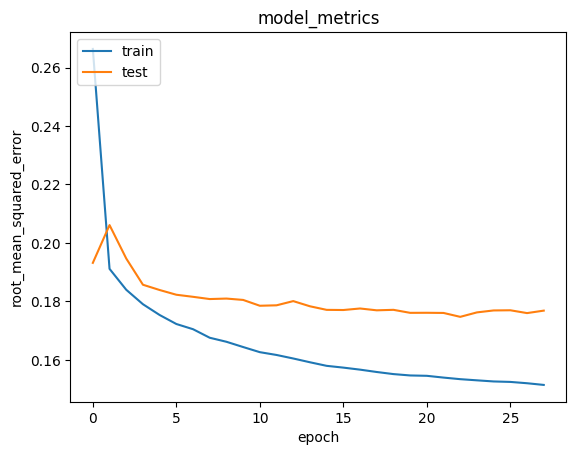

In [34]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Mendapatkan Rekomendasi Buku

Tahap ini bertujuan untuk memberikan rekomendasi buku personal kepada pengguna berdasarkan hasil prediksi model Collaborative Filtering. Langkah-langkah yang dilakukan:

- Memilih seorang pengguna secara acak.
- Menentukan daftar buku yang belum pernah diberi rating oleh pengguna tersebut.
- Melakukan encoding user dan buku untuk proses prediksi.
- Menggunakan model untuk menghitung prediksi skor rating.
- Menampilkan 10 buku dengan skor tertinggi sebagai rekomendasi personal.
- Menampilkan 5 buku yang sebelumnya mendapat rating tinggi dari user sebagai referensi preferensi.



In [43]:
# Copy hasil rating setelah filtering dan preprocessing
rating_df = ratings.copy()

# Copy data dataframe buku asli (untuk info judul)
book_df = books.copy()

# Pilih satu user secara acak
user_id = rating_df['User-ID'].sample(1).iloc[0]
books_rating_by_user = rating_df[rating_df['User-ID'] == user_id]

# Ambil daftar ISBN buku yang belum pernah dibaca/dirating user
# Variabel books_not_rating diperoleh dengan menggunakan operator bitwise (~) pada variabel books_rating_by_user
books_not_rating = book_df[~book_df['ISBN'].isin(books_rating_by_user['ISBN'].values)]['ISBN']
books_not_rating = list(
    set(books_not_rating)
    .intersection(set(book_to_book_encoded.keys()))
)

# Encoding data buku belum dibaca/dirating dan user terkait
books_not_rating_encoded = [[book_to_book_encoded.get(x)] for x in books_not_rating]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(books_not_rating_encoded), books_not_rating_encoded)
)

In [44]:
# Prediksi rating untuk buku-buku yang belum dibaca user
ratings_pred = model.predict(user_book_array).flatten()

# Ambil 10 prediksi tertinggi
top_ratings_indices = ratings_pred.argsort()[-10:][::-1]
recommended_book_isbns = [
    book_encoded_to_book.get(books_not_rating_encoded[x][0]) for x in top_ratings_indices
]

print(f'\n Showing recommendations for user: {user_id}')
print('=' * 40)

# === Tampilkan Buku-Buku Favorit User ===
print('\n Books with high ratings from user:')
# Ambil buku yang dirating tinggi user, termasuk ratingnya
top_books_user_with_rating = (
    books_rating_by_user # Gunakan dataframe yang sudah berisi rating user
    .sort_values(by='Book-Rating', ascending=False)
    .head(5)
    [['ISBN', 'Book-Rating']] # Ambil ISBN dan Book-Rating
)

# Gabungkan dengan info buku (judul, penulis)
top_books_user_df = pd.merge(
    top_books_user_with_rating,
    book_df[['ISBN', 'Book-Title', 'Book-Author']],
    on='ISBN',
    how='left'
)

# Pilih kolom yang ingin ditampilkan dan urutkan kembali
top_books_user_df = top_books_user_df[['Book-Title', 'Book-Author', 'Book-Rating']]
top_books_user_df.index = range(1, len(top_books_user_df) + 1)
print(top_books_user_df.to_markdown()) # Tampilkan dalam format markdown table

# === Tampilkan Rekomendasi ===
print('\n Top 10 Book Recommendations:')
recommended_books_df = book_df[book_df['ISBN'].isin(recommended_book_isbns)].copy()

# Tambahkan kolom Predicted-Rating dari hasil prediksi
# ratings_pred adalah prediksi skala 0-1. Ambil prediksi yang sesuai dengan top 10 ISBN
predicted_ratings_for_top10 = ratings_pred[top_ratings_indices]
recommended_books_df['Predicted-Rating-Scale'] = predicted_ratings_for_top10

# Optional: Kembalikan prediksi ke skala rating asli (misalnya 1–10)
# Anda perlu menggunakan min_rating dan max_rating yang didapatkan dari data training 1-10
# Pastikan min_rating dan max_rating didefinisikan di sel sebelumnya
# min_rating = ratings['Book-Rating'].min() setelah filter 0 dan sparsity
# max_rating = ratings['Book-Rating'].max() setelah filter 0 dan sparsity
recommended_books_df['Predicted-Rating'] = recommended_books_df['Predicted-Rating-Scale'] * (max_rating - min_rating) + min_rating
recommended_books_df['Predicted-Rating'] = recommended_books_df['Predicted-Rating'].round(2) # Bulatkan 2 angka desimal

# Pilih kolom yang ingin ditampilkan dan urutkan berdasarkan prediksi
recommended_books_df = recommended_books_df[['Book-Title', 'Book-Author', 'Predicted-Rating']]
recommended_books_df = recommended_books_df.sort_values(by='Predicted-Rating', ascending=False).reset_index(drop=True)
recommended_books_df.index = range(1, len(recommended_books_df) + 1)

print(recommended_books_df.to_markdown()) # Tampilkan dalam format markdown table

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 Showing recommendations for user: 21014

 Books with high ratings from user:
|    | Book-Title                                        | Book-Author          |   Book-Rating |
|---:|:--------------------------------------------------|:---------------------|--------------:|
|  1 | One True Thing                                    | Anna Quindlen        |            10 |
|  2 | On the Banks of Plum Creek                        | Laura Ingalls Wilder |            10 |
|  3 | Charlotte's Web (Trophy Newbery)                  | E. B. White          |            10 |
|  4 | Charlie and the Chocolate Factory (Puffin Novels) | Roald Dahl           |            10 |
|  5 | These Happy Golden Years (Little House)           | Laura Ingalls Wilder |            10 |

 Top 10 Book Recommendations:
|    | Book-Title                                                        | Book-Author      |   Predicted-Rating |
|---:|:-----------------------------------------